In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit import QuantumRegister,ClassicalRegister
from qiskit_machine_learning.neural_networks import EstimatorQNN,SamplerQNN
from IPython.display import clear_output
import matplotlib.pyplot as plt
import qiskit.quantum_info as qi
from qiskit.circuit import ParameterVector
from qiskit_algorithms.utils import algorithm_globals
import time 
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import EfficientSU2,RealAmplitudes
import numpy as np

import pickle 
import time
from qiskit.circuit.library import iSwapGate
from math import comb

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator
sqrt_iSWAP = iSwapGate().power(1/2)

from matplotlib import colormaps
list(colormaps)
cmap = 'gist_heat'

from Z2_2flavourClass import Z2_2flavour

In [18]:
# matter_defect = [7,12]
# nLinks = 7

matter_defect = np.array([7,9])
nLinks = 5
# charge_loc_initial = (nLinks*3+2) - matter_defect
# print(charge_loc_initial)
nShots = 100000 

dtFactor = 0.2
Trotter_time = np.arange(dtFactor,10*dtFactor,dtFactor)
nTrotter_total = Trotter_time.shape[0]
dt_min = 0.4
nTrotter_list = np.ceil(Trotter_time/dt_min)
dt_list = Trotter_time/nTrotter_list


[10  8]


In [3]:
# string_name = 'stringList_Kawasaki_23Rescaling_2025-02-28_nCharges_2.pkl'
string_name = 'stringList_torino_17Rescaling_2025-02-28_nCharges_2.pkl.pkl'

In [4]:
with open(string_name, 'rb') as file:
    string_list_rescale = pickle.load(file)

In [5]:
string_list_rescale

{'nTrotter_2_dtRescale_0.30000000000000004': [{'11101010001011000': 10,
   '11011011000011011': 119,
   '10011011010011111': 2,
   '11001010011011011': 110,
   '11011010001001011': 401,
   '11010101100011111': 2,
   '00111010001011001': 14,
   '11011110011111101': 7,
   '10011010011101011': 60,
   '11011011001111110': 8,
   '11001000010011110': 3,
   '11101000001011011': 40,
   '11010000001001010': 2,
   '11011011010011010': 6,
   '10111010000011000': 6,
   '11110010111101010': 1,
   '11011110000001011': 5,
   '11011010000011011': 688,
   '11011010011111011': 140,
   '11010010000100110': 3,
   '11101010000101011': 4,
   '10011010000110000': 4,
   '11001010000011011': 102,
   '10110010000011011': 19,
   '11000000001011010': 7,
   '11011101000010011': 5,
   '10001010001011011': 202,
   '10111000001011001': 6,
   '10011011001001001': 5,
   '11000001001011010': 7,
   '11011110001100110': 4,
   '11001111001011001': 7,
   '11011010010011011': 230,
   '11110001100011111': 1,
   '1001101000101

In [6]:
def getChargeArr(strings): #input is a job result
    p_list = []
    
    charge1 = np.zeros(nLinks+1)
    charge2 = np.zeros(nLinks+1)
    weights_all = 0
    
    for key in strings.keys():
        tmpKey = np.array([int(numeric_string) for numeric_string in key])  
        tmpKey = 1-tmpKey
        weight = strings[key]
        #arr = 1 - 2*tmpKey
        
        tmp_charge1 = []
        tmp_charge2 = []
        for i in range(len(tmpKey)):
            if (i+1)%3 == 1:
                tmp_charge1.append(tmpKey[i])
            elif (i+1)%3 == 2:
                tmp_charge2.append(tmpKey[i])
                
        tmp_charge1 = np.array(tmp_charge1)
        tmp_charge2 = np.array(tmp_charge2)

        if tmp_charge1.sum() == 1 and tmp_charge2.sum() == 1:
            weights_all += weight
            charge1 += np.array(tmp_charge1)*weight
            charge2 += np.array(tmp_charge2)*weight
            

    return charge1, charge2, weights_all
            
    
def getChargeLoc_fromString(string_list_dict):

    prob1 = []
    prob2 = []
    for key in string_list_dict.keys(): #each time step
        print(key)
        evs_list_tmp = []
        l = string_list_dict[key]
        
        charge1 = np.zeros(nLinks+1)
        charge2 = np.zeros(nLinks+1)
        weights_all = 0
        for strings in l: #bundle of jobs in each time step, iterate to get each job
            tmp_c1, tmp_c2, weight = getChargeArr(strings)
            weights_all += weight
            charge1 += np.array(tmp_c1)
            charge2 += np.array(tmp_c2)
            

            
        charge1 = charge1 / weights_all
        charge2 = charge2 / weights_all

        
        prob1.append(charge1)
        prob2.append(charge2)
        
    return np.array(prob1), np.array(prob2)   

In [7]:
p_charge1, p_charge2 = getChargeLoc_fromString(string_list_rescale)

nTrotter_2_dtRescale_0.30000000000000004
nTrotter_2_dtRescale_0.4
nTrotter_4_dtRescale_0.35000000000000003
nTrotter_4_dtRescale_0.4


In [8]:
p_charge1_n2 = (p_charge1[0]+p_charge1[1])/2
p_charge2_n2 = (p_charge2[0]+p_charge2[1])/2

p_charge1_n4 = (p_charge1[2]+p_charge1[3])/2
p_charge2_n4 = (p_charge2[2]+p_charge2[3])/2

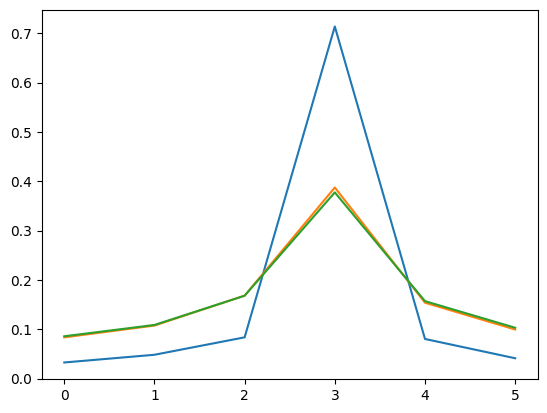

In [9]:
plt.plot(p_charge1_n2)
plt.plot(p_charge1_n4)
plt.plot(p_charge1[3])

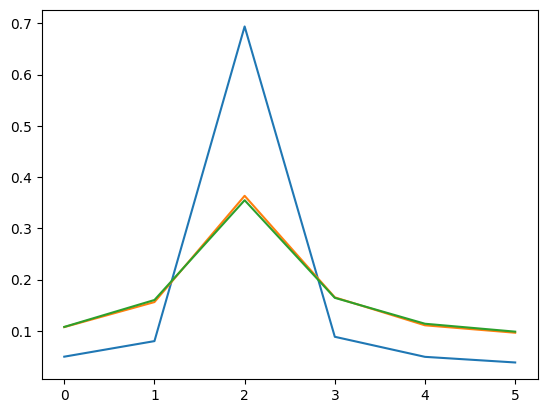

In [10]:
plt.plot(p_charge2_n2)
plt.plot(p_charge2_n4)
plt.plot(p_charge2[3])

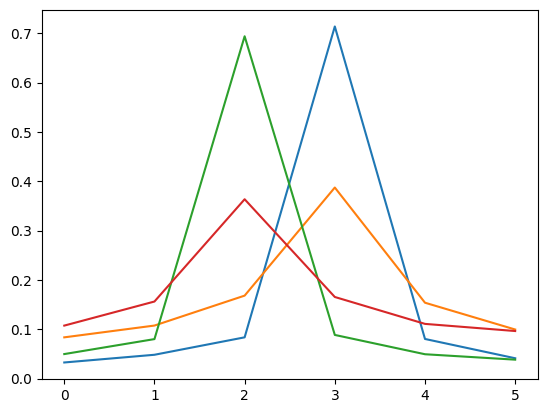

In [11]:
plt.plot(p_charge1_n2)
plt.plot(p_charge1_n4)
plt.plot(p_charge2_n2)
plt.plot(p_charge2_n4)

In [13]:
def getbkg(arr):
    return (arr.sum() - arr.max())/(arr.shape[0])

In [16]:
print(getbkg(p_charge1_n2), getbkg(p_charge2_n2)," avg = ", (getbkg(p_charge1_n2) + getbkg(p_charge2_n2))/2)
print(getbkg(p_charge1_n4), getbkg(p_charge2_n4)," avg = ", (getbkg(p_charge1_n4) + getbkg(p_charge2_n4))/2)

0.04771118886467388 0.051022486034155566  avg =  0.049366837449414724
0.10211673529347125 0.10607790990741421  avg =  0.10409732260044273
